In [1]:
from theFuncs import *

# DATA

In [2]:
# load_DTB3_SPY().to_csv('./data/spy_dtb3.csv')

In [3]:
sp100 = os.listdir(os.getcwd()+'/data/stock_dfs')
sp100_tickers = []
for csvfile in sp100:
    sp100_tickers.append(csvfile[:-4])

# sp100_tickers

In [4]:
ticker_data = get_ticker_data_multisource(sp100_tickers)

In [5]:
# nyse_tickers_cap = pd.read_csv("data/tickers_nyse.csv", index_col=0).MarketCap.dropna().apply(
#     lambda x: float(x[1: -1]) * 1e6 if x[-1] == "M" else float(x[1: -1]) * 1e6
# ).sort_values(ascending=False)[:200]

# nyse_tickers = nyse_tickers_cap.index

In [6]:
# nyse_ticker_weights = nyse_tickers_cap / nyse_tickers_cap.sum()
# nyse_ticker_weights.head()

In [7]:
# ticker_data = get_ticker_data_multisource(nyse_tickers)

In [8]:
tickers = sp100_tickers

model = RollingOLS.from_formula(
        "(ret - DTB3) ~ (spy_ret - DTB3)", 
        data = ticker_data.loc[tickers[0]], 
        window = 66
    ).fit(params_only=True)
df = model.params
df.columns = ["alpha", "Beta"]
df['ticker'] = tickers[0]
df.set_index('ticker', inplace=True, append=True)
df = df.reorder_levels(['ticker', 'date']).sort_index()


for ticker in tickers[1:]:
    model = RollingOLS.from_formula(
        "(ret - DTB3) ~ (spy_ret - DTB3)", 
        data = ticker_data.loc[ticker], 
        window = 66
    ).fit(params_only=True)

    temp = model.params
    temp.columns = ["alpha", "Beta"]
    temp['ticker'] = ticker
    temp.set_index('ticker', inplace=True, append=True)
    temp = temp.reorder_levels(['ticker', 'date']).sort_index()
    df = pd.concat(
        [ 
            df, 
            temp
        ]
    )

ticker_data = ticker_data.join(df)

ticker_data.head()

high        low       open      close       volume  \
ticker date                                                                  
AAPL   2019-01-03  36.430000  35.500000  35.994999  35.547501  365248800.0   
       2019-01-04  37.137501  35.950001  36.132500  37.064999  234428400.0   
       2019-01-07  37.207500  36.474998  37.174999  36.982498  219111200.0   
       2019-01-08  37.955002  37.130001  37.389999  37.687500  164101200.0   
       2019-01-09  38.632500  37.407501  37.822498  38.327499  180396400.0   

                        ret   spy_close    DTB3   spy_ret  alpha  Beta  
ticker date                                                             
AAPL   2019-01-03 -0.099607  232.998627  0.0236 -0.023863    NaN   NaN  
       2019-01-04  0.042689  240.803085  0.0237  0.033496    NaN   NaN  
       2019-01-07 -0.002226  242.701736  0.0241  0.007885    NaN   NaN  
       2019-01-08  0.019063  244.981995  0.0241  0.009395    NaN   NaN  
       2019-01-09  0.016982  246.126907  0.0240  0.004673    NaN   NaN

In [9]:
market_caps = pd.DataFrame(
    ticker_data.close * ticker_data.volume,
    columns=["MarketCap"]
)
market_caps.head()

MarketCap
ticker date                    
AAPL   2019-01-03  1.298368e+10
       2019-01-04  8.689088e+09
       2019-01-07  8.103280e+09
       2019-01-08  6.184564e+09
       2019-01-09  6.914143e+09

In [10]:
market_caps = market_caps.ewm(66).mean()

In [11]:
market_caps.head()

MarketCap
ticker date                    
AAPL   2019-01-03  1.298368e+10
       2019-01-04  1.082024e+10
       2019-01-07  9.900934e+09
       2019-01-08  8.950780e+09
       2019-01-09  8.531111e+09

In [12]:
ticker_data_wide = ticker_data.reset_index(level=['ticker', 'date'])
ticker_data_wide = ticker_data_wide[['ticker', 'date', 'ret']].pivot(
    index='date', 
    columns='ticker', 
    values='ret'
)
ticker_data_wide.head()

ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.099607,-0.032949,-0.047194,-0.034142,-0.039498,-0.021959,-0.015216,0.005997,-0.025242,-0.088951,...,-0.027270,-0.037016,-0.028392,-0.014024,-0.036037,0.003570,-0.010435,-0.007882,-0.005142,-0.015354
2019-01-04,0.042689,0.032217,0.028541,0.038884,0.048632,0.036903,0.034184,0.003995,0.050064,0.009828,...,0.011695,0.038514,0.034833,0.024726,0.043081,0.002490,0.033269,0.029633,0.006246,0.036870
2019-01-07,-0.002226,0.014595,0.014976,0.003473,0.013573,0.005724,0.013457,0.006190,0.034353,0.020366,...,0.001920,0.006241,-0.003376,-0.004698,0.018032,0.006388,0.005750,-0.006465,0.011772,0.005200
2019-01-08,0.019063,0.004648,-0.012006,0.025290,0.014918,0.003959,0.012824,0.011300,0.016612,-0.008026,...,0.013371,0.087270,0.000103,0.006436,0.005439,0.029267,0.020009,-0.002099,0.006981,0.007271
2019-01-09,0.016982,-0.032823,0.016691,0.005030,0.011819,0.014543,-0.001196,-0.008753,0.001714,0.043250,...,0.001439,-0.002587,0.005132,0.010659,0.011769,-0.022782,0.012050,0.005469,-0.003256,0.005275


In [13]:
rolling_correlations = ticker_data_wide.rolling(66).corr().dropna()
rolling_correlations.head()

ticker                 AAPL      ABBV       ABT       ACN      ADBE       AIG  \
date       ticker                                                               
2019-06-24 AAPL    1.000000  0.296962  0.224228  0.354141  0.403017 -0.057218   
           ABBV    0.296962  1.000000  0.495805  0.338759  0.345130 -0.007118   
           ABT     0.224228  0.495805  1.000000  0.447644  0.510348  0.037750   
           ACN     0.354141  0.338759  0.447644  1.000000  0.527017  0.108172   
           ADBE    0.403017  0.345130  0.510348  0.527017  1.000000  0.123667   

ticker                 AMGN       AMT      AMZN      AVGO  ...       UNH  \
date       ticker                                          ...             
2019-06-24 AAPL    0.248007 -0.039255  0.561013  0.606993  ...  0.117699   
           ABBV    0.515949  0.102796  0.376902  0.127400  ...  0.410813   
           ABT     0.539751  0.297049  0.391182  0.299744  ...  0.388814   
           ACN     0.283967  0.152951  0.498013  0.369200  ...  0.136531   
           ADBE    0.302570  0.199119  0.739261  0.418718  ...  0.211514   

ticker                  UNP       UPS       USB         V        VZ       WBA  \
date       ticker                                                               
2019-06-24 AAPL    0.370165  0.409476  0.366545  0.501574 -0.112949  0.228087   
           ABBV    0.188250  0.153467  0.285019  0.448157  0.079838 -0.087340   
           ABT     0.297078  0.199606  0.363545  0.472988 -0.019647  0.103246   
           ACN     0.385596  0.390947  0.351905  0.621636 -0.238056  0.252542   
           ADBE    0.455503  0.293439  0.379133  0.820151 -0.091270  0.225878   

ticker                  WFC       WMT       XOM  
date       ticker                                
2019-06-24 AAPL    0.301752  0.151945  0.301929  
           ABBV    0.270842  0.111515  0.323539  
           ABT     0.339443  0.308035  0.302968  
           ACN     0.317963  0.330239  0.318322  
           ADBE    0.256738  0.357301  0.303250  

[5 rows x 101 columns]

In [14]:
rolling_covariances = ticker_data_wide.rolling(66).cov().dropna()
rolling_covariances.head()

ticker                 AAPL      ABBV       ABT       ACN      ADBE       AIG  \
date       ticker                                                               
2019-06-24 AAPL    0.000275  0.000051  0.000043  0.000060  0.000111 -0.000013   
           ABBV    0.000051  0.000107  0.000060  0.000036  0.000059 -0.000001   
           ABT     0.000043  0.000060  0.000137  0.000054  0.000099  0.000006   
           ACN     0.000060  0.000036  0.000054  0.000105  0.000089  0.000015   
           ADBE    0.000111  0.000059  0.000099  0.000089  0.000274  0.000028   

ticker                 AMGN       AMT      AMZN      AVGO  ...       UNH  \
date       ticker                                          ...             
2019-06-24 AAPL    0.000049 -0.000006  0.000133  0.000189  ...  0.000032   
           ABBV    0.000063  0.000010  0.000056  0.000025  ...  0.000069   
           ABT     0.000075  0.000034  0.000066  0.000066  ...  0.000074   
           ACN     0.000034  0.000015  0.000073  0.000071  ...  0.000023   
           ADBE    0.000059  0.000033  0.000175  0.000130  ...  0.000057   

ticker                  UNP       UPS       USB         V        VZ       WBA  \
date       ticker                                                               
2019-06-24 AAPL    0.000070  0.000110  0.000058  0.000078 -0.000023  0.000073   
           ABBV    0.000022  0.000026  0.000028  0.000044  0.000010 -0.000017   
           ABT     0.000040  0.000038  0.000041  0.000052 -0.000003  0.000023   
           ACN     0.000045  0.000065  0.000035  0.000060 -0.000030  0.000050   
           ADBE    0.000086  0.000079  0.000060  0.000127 -0.000019  0.000072   

ticker                  WFC       WMT       XOM  
date       ticker                                
2019-06-24 AAPL    0.000061  0.000021  0.000054  
           ABBV    0.000034  0.000009  0.000036  
           ABT     0.000048  0.000030  0.000038  
           ACN     0.000039  0.000028  0.000035  
           ADBE    0.000051  0.000049  0.000054  

[5 rows x 101 columns]

In [15]:
rolling_covariances.loc[('2019-06-24', 'AAPL'), 'AAPL']

date        ticker
2019-06-24  AAPL      0.000275
Name: AAPL, dtype: float64

# CLUSTERING

In [16]:
date = get_closest_trading_day("2020-03-23", ticker_data)
K = 10

In [17]:
x, y, z = clustering_model(rolling_correlations, date, K, GRB.MINIMIZE)

Academic license - for non-commercial use only - expires 2022-08-27
Using license file /Users/karimlayoun/gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10303 rows, 10302 columns and 30704 nonzeros
Model fingerprint: 0xd2802826
Variable types: 0 continuous, 10302 integer (10302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 74.2899934
Presolve time: 0.05s
Presolved: 10303 rows, 10302 columns, 30704 nonzeros
Variable types: 0 continuous, 10302 integer (10302 binary)

Root relaxation: objective 3.112712e+01, 117 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     

# INDEX BY CLUSTER WEIGHTS

In [18]:
z_market_cap = market_caps.loc[
    market_caps.index.get_level_values(1) == date
].join(z)
z_market_cap.reset_index(drop=True, level=1, inplace=True)

In [19]:
center_weights = z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].groupby("center").MarketCap.sum() / z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].MarketCap.sum()

In [20]:
portfolio_returns = get_portfolio_returns(
    center_weights, date, ticker_data_wide
)
spy_returns = get_spy_returns(date)

portfolio_returns, spy_returns

(1.4533245604505582, 1.3698565655777577)

In [21]:
portfolio_returns - spy_returns

0.08346799487280054

In [22]:
get_portfolio_beta(center_weights, date, ticker_data)

0.7617658257575273

In [23]:
# master_func("2020-03-23", K, rolling_correlations, market_caps, ticker_data, ticker_data_wide, rolling_covariances, 0.5, 1.5, 1e-3)

# INDEX BY MIN VAR

In [24]:
mean_var_step, obj = mean_variance_model(
    market_caps, 
    ticker_data, 
    date, 
    rolling_covariances, 
    center_weights,
    0.5, 
    1.5, 
    1e-3
)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 99 rows, 101 columns and 499 nonzeros
Model fingerprint: 0x53a8f478
Model has 5151 quadratic objective terms
Coefficient statistics:
  Matrix range     [5e-06, 2e+00]
  Objective range  [9e-04, 3e-03]
  QObjective range [2e-04, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 96 rows and 95 columns
Presolve time: 0.00s
Presolved: 3 rows, 7 columns, 19 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 2.800e+01
 Factor NZ  : 3.600e+01
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.28573197e+05 -4.28812869e+05  3.50e+03 4.97e-02  4.30e+05     0s
   1   1.1

In [25]:
obj

0.009278057044917857

In [26]:
mean_var_step_return = get_portfolio_returns(mean_var_step.weights, date, ticker_data_wide)
mean_var_step_return, spy_returns

(1.3773336965615866, 1.3698565655777577)

In [27]:
mean_var_step_return - spy_returns

0.00747713098382885

In [28]:
get_portfolio_beta(mean_var_step.weights, date, ticker_data)

0.9475758218061204

# Method Comparison

In [29]:
pd.concat(
    [
        mean_var_step[mean_var_step.weights > 0], 
        center_weights
    ], 
    axis=1
)

,weights,MarketCap
center,,
GILD,0.072965,0.561221
GM,0.138455,0.008925
SPG,0.101607,0.012760
TMO,0.180403,0.020692
TSLA,0.180014,0.320060
WBA,0.326555,0.076342


# Master Func

In [39]:
start_date = get_closest_trading_day("2020-01-01", ticker_data)
end_date = max(ticker_data.index.get_level_values("date"))

master_cluster_index = {}
master_cluster_performance = {}
master_mean_var_index = {}
master_mean_var_performance = {}

while start_date < end_date:
    master_func(
        start_date, 
        K, 
        rolling_correlations, 
        market_caps, 
        ticker_data, 
        ticker_data_wide, 
        rolling_covariances,
        0.5, 
        1.5, 
        1e-3, 
        master_cluster_index,
        master_cluster_performance,
        master_mean_var_index,
        master_mean_var_performance, 
        # GRB.MINIMIZE
        )

    start_date += relativedelta(months=3)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10303 rows, 10302 columns and 30704 nonzeros
Model fingerprint: 0x3f54aaf5
Variable types: 0 continuous, 10302 integer (10302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 27.2872944
Presolve time: 0.05s
Presolved: 10303 rows, 10302 columns, 30704 nonzeros
Variable types: 0 continuous, 10302 integer (10302 binary)

Root relaxation: objective 6.130220e+01, 979 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   61.30220    0  140   27.28729   61.30220   125%     -    0s
H    0     0                      60.9229965   61.30220  0.62%     -    0s


In [40]:
method1_index = pd.DataFrame.from_dict(master_cluster_index, orient="index")
method1_index

weight
2019-12-31 DHR   0.067111
           HD    0.041691
           INTC  0.094902
           JNJ   0.058488
           KO    0.065488
...                   ...
2021-09-30 MDLZ  0.040649
           MET   0.321626
           MSFT  0.382637
           SO    0.009910
           UPS   0.009344

[80 rows x 1 columns]

<AxesSubplot:>

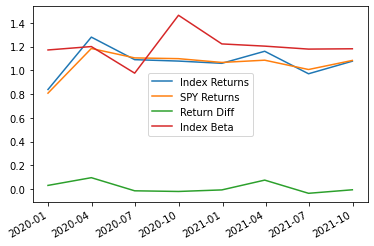

In [41]:
method1_performance = pd.DataFrame.from_dict(master_cluster_performance, orient="index")
method1_performance.plot()

In [42]:
method2_index = pd.DataFrame.from_dict(master_mean_var_index, orient="index")
method2_index

weight
2019-12-31 DHR   7.164738e-07
           HD    8.264053e-07
           INTC  1.063613e-01
           JNJ   1.555950e-01
           KO    2.782510e-02
...                       ...
2021-06-30 MET   3.719814e-02
           MRK   1.214722e-01
           PYPL  3.045789e-01
           TMO   5.565815e-02
           TXN   2.731937e-07

[70 rows x 1 columns]

<AxesSubplot:>

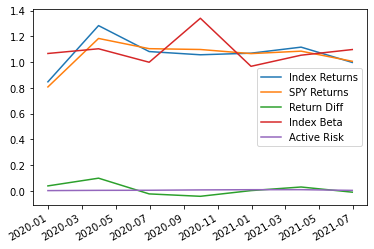

In [43]:
method2_performance = pd.DataFrame.from_dict(master_mean_var_performance, orient="index")
method2_performance.plot()

In [44]:
comp_index = method1_index.join(
    method2_index, 
    lsuffix="_cluster", 
    rsuffix="_opti"
)
comp_index

weight_cluster   weight_opti
2019-12-31 DHR         0.067111  7.164738e-07
           HD          0.041691  8.264053e-07
           INTC        0.094902  1.063613e-01
           JNJ         0.058488  1.555950e-01
           KO          0.065488  2.782510e-02
...                         ...           ...
2021-09-30 MDLZ        0.040649           NaN
           MET         0.321626           NaN
           MSFT        0.382637           NaN
           SO          0.009910           NaN
           UPS         0.009344           NaN

[80 rows x 2 columns]

In [45]:
comp_performance = method1_performance.join(
    method2_performance, 
    lsuffix="_cluster", 
    rsuffix="_opti"
)
comp_performance

,Index Returns_cluster,SPY Returns_cluster,Return Diff_cluster,Index Beta_cluster,Index Returns_opti,SPY Returns_opti,Return Diff_opti,Index Beta_opti,Active Risk
2019-12-31,0.838131,0.807480,0.030651,1.171190,0.847196,0.807480,0.039716,1.067092,0.003196
2020-03-31,1.279422,1.183707,0.095715,1.199930,1.283312,1.183707,0.099605,1.103665,0.005174
2020-06-30,1.089522,1.104351,-0.014829,0.975907,1.081942,1.104351,-0.022409,0.999108,0.005887
2020-09-30,1.077632,1.098023,-0.020390,1.463445,1.057025,1.098023,-0.040998,1.340296,0.008598
2020-12-30,1.058793,1.066125,-0.007332,1.222150,1.069325,1.066125,0.003200,0.967542,0.010185
2021-03-30,1.160308,1.085099,0.075209,1.203494,1.116254,1.085099,0.031155,1.053771,0.010492
2021-06-30,0.970716,1.006581,-0.035866,1.178493,0.997521,1.006581,-0.009060,1.097585,0.004945
2021-09-30,1.076759,1.083037,-0.006278,1.181244,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

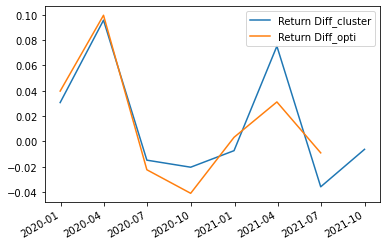

In [46]:
comp_performance.plot(y=["Return Diff_cluster", "Return Diff_opti"])

<AxesSubplot:>

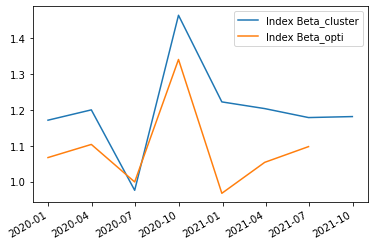

In [47]:
comp_performance.plot(y=["Index Beta_cluster", "Index Beta_opti"])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=80cc924b-f00e-4408-bf29-ac16ba2efaff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>